Convolutional Dictionary Learning
=================================

This example demonstrates the use of [dictlrn.cbpdndl.ConvBPDNDictLearn](http://sporco.rtfd.org/en/latest/modules/sporco.dictlrn.cbpdndl.html#sporco.dictlrn.cbpdndl.ConvBPDNDictLearn) for learning a 3D convolutional dictionary from video data. The dictionary learning algorithm is based on the ADMM consensus dictionary update.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import os.path
import tempfile
import sys

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np
from scipy.ndimage import zoom
import imageio

from sporco.dictlrn import cbpdndl
from sporco import util
from sporco import plot
plot.config_notebook_plotting()

Construct 3D training array from video data

In [2]:
reader = imageio.get_reader('imageio:cockatoo.mp4')
nfrm = reader.get_length()
frmlst = []
for i, frm in enumerate(reader):
    if i >= 250:
        frm = zoom(util.rgb2gray(frm.astype(np.float32)/255.0), 0.25)
        frmlst.append(frm[20:-20, 70:-70])
vid = np.stack(frmlst, axis=2)

Highpass filter video frames.

In [3]:
npd = 16
fltlmbd = 10
vl, vh = util.tikhonov_filter(vid, fltlmbd, npd)

Construct initial dictionary.

In [4]:
np.random.seed(12345)
D0 = np.random.randn(5, 5, 3, 25)

Set regularization parameter and options for dictionary learning solver.

In [5]:
lmbda = 0.1
opt = cbpdndl.ConvBPDNDictLearn.Options({'Verbose': True, 'MaxMainIter': 200,
                'CBPDN': {'rho': 5e1*lmbda, 'AutoRho': {'Enabled': True}},
                'CCMOD': {'rho': 1e2, 'AutoRho': {'Enabled': True}}},
                dmethod='cns')

Create solver object and solve.

In [6]:
d = cbpdndl.ConvBPDNDictLearn(D0, vh, lmbda, opt, dimK=0, dimN=3)
D1 = d.solve()
print("ConvBPDNDictLearn solve time: %.2fs" % d.timer.elapsed('solve'))

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------


   0  1.84e+03  2.73e+01  1.81e+04  3.67e-07  9.68e-01  9.02e-02  5.00e+00  2.39e-01  1.74e-01  1.00e+02


   1  1.29e+03  1.23e+02  1.17e+04  4.69e-07  8.09e-01  2.18e-01  5.00e+00  2.59e-01  2.08e-01  1.00e+02


   2  1.13e+03  1.47e+02  9.82e+03  3.60e-07  4.33e-01  2.26e-01  5.00e+00  2.47e-01  1.53e-01  1.00e+02


   3  1.06e+03  1.39e+02  9.23e+03  4.53e-07  3.16e-01  1.91e-01  5.00e+00  2.08e-01  9.80e-02  1.00e+02


   4  9.66e+02  1.30e+02  8.36e+03  4.44e-07  2.60e-01  1.54e-01  5.00e+00  1.73e-01  7.98e-02  1.00e+02


   5  8.39e+02  1.27e+02  7.12e+03  4.59e-07  2.14e-01  1.25e-01  5.00e+00  1.41e-01  7.31e-02  1.00e+02


   6  7.53e+02  1.28e+02  6.25e+03  5.38e-07  1.81e-01  9.83e-02  5.00e+00  1.17e-01  7.19e-02  1.00e+02


   7  6.99e+02  1.29e+02  5.69e+03  4.67e-07  1.51e-01  7.90e-02  5.00e+00  9.55e-02  6.54e-02  1.00e+02


   8  6.60e+02  1.30e+02  5.30e+03  4.26e-07  1.27e-01  6.85e-02  5.00e+00  8.00e-02  5.89e-02  1.00e+02


   9  6.36e+02  1.29e+02  5.07e+03  4.49e-07  1.08e-01  6.15e-02  5.00e+00  6.80e-02  5.37e-02  1.00e+02


  10  6.14e+02  1.28e+02  4.86e+03  4.41e-07  9.44e-02  5.47e-02  5.00e+00  5.75e-02  5.04e-02  1.00e+02


  11  6.00e+02  1.27e+02  4.73e+03  5.00e-07  8.38e-02  4.90e-02  5.00e+00  4.96e-02  4.75e-02  1.00e+02


  12  5.78e+02  1.25e+02  4.53e+03  4.62e-07  7.46e-02  4.50e-02  5.00e+00  4.38e-02  4.50e-02  1.00e+02


  13  5.61e+02  1.24e+02  4.37e+03  5.08e-07  6.75e-02  4.16e-02  5.00e+00  3.92e-02  4.26e-02  1.00e+02


  14  5.43e+02  1.23e+02  4.20e+03  4.20e-07  6.11e-02  3.84e-02  5.00e+00  3.52e-02  4.05e-02  1.00e+02


  15  5.32e+02  1.23e+02  4.09e+03  4.27e-07  5.61e-02  3.56e-02  5.00e+00  3.20e-02  3.85e-02  1.00e+02


  16  5.20e+02  1.22e+02  3.98e+03  5.63e-07  5.16e-02  3.32e-02  5.00e+00  2.92e-02  3.67e-02  1.00e+02


  17  5.12e+02  1.21e+02  3.91e+03  5.46e-07  4.81e-02  3.13e-02  5.00e+00  2.69e-02  3.49e-02  1.00e+02


  18  5.03e+02  1.21e+02  3.83e+03  4.95e-07  4.49e-02  2.96e-02  5.00e+00  2.50e-02  3.33e-02  1.00e+02


  19  4.97e+02  1.20e+02  3.77e+03  4.90e-07  4.23e-02  2.81e-02  5.00e+00  2.33e-02  3.18e-02  1.00e+02


  20  4.89e+02  1.19e+02  3.69e+03  5.56e-07  3.97e-02  2.66e-02  5.00e+00  2.18e-02  3.03e-02  1.00e+02


  21  4.82e+02  1.19e+02  3.63e+03  5.49e-07  3.76e-02  2.53e-02  5.00e+00  2.05e-02  2.89e-02  1.00e+02


  22  4.75e+02  1.18e+02  3.57e+03  5.05e-07  3.56e-02  2.42e-02  5.00e+00  1.94e-02  2.75e-02  1.00e+02


  23  4.70e+02  1.18e+02  3.52e+03  4.28e-07  3.39e-02  2.31e-02  5.00e+00  1.85e-02  2.63e-02  1.00e+02


  24  4.65e+02  1.18e+02  3.47e+03  4.48e-07  3.22e-02  2.21e-02  5.00e+00  1.75e-02  2.52e-02  1.00e+02


  25  4.61e+02  1.17e+02  3.44e+03  5.06e-07  3.07e-02  2.13e-02  5.00e+00  1.67e-02  2.41e-02  1.00e+02


  26  4.57e+02  1.17e+02  3.40e+03  4.04e-07  2.93e-02  2.05e-02  5.00e+00  1.59e-02  2.32e-02  1.00e+02


  27  4.53e+02  1.17e+02  3.36e+03  4.84e-07  2.80e-02  1.97e-02  5.00e+00  1.53e-02  2.22e-02  1.00e+02


  28  4.49e+02  1.16e+02  3.33e+03  4.68e-07  2.68e-02  1.90e-02  5.00e+00  1.45e-02  2.14e-02  1.00e+02


  29  4.46e+02  1.16e+02  3.30e+03  4.65e-07  2.57e-02  1.84e-02  5.00e+00  1.39e-02  2.05e-02  1.00e+02


  30  4.42e+02  1.16e+02  3.26e+03  5.06e-07  2.47e-02  1.77e-02  5.00e+00  1.33e-02  1.97e-02  1.00e+02


  31  4.39e+02  1.16e+02  3.23e+03  4.90e-07  2.37e-02  1.71e-02  5.00e+00  1.28e-02  1.90e-02  1.00e+02


  32  4.36e+02  1.15e+02  3.20e+03  4.64e-07  2.27e-02  1.65e-02  5.00e+00  1.23e-02  1.83e-02  1.00e+02


  33  4.33e+02  1.15e+02  3.18e+03  5.20e-07  2.18e-02  1.60e-02  5.00e+00  1.18e-02  1.76e-02  1.00e+02


  34  4.30e+02  1.15e+02  3.15e+03  4.17e-07  2.09e-02  1.55e-02  5.00e+00  1.13e-02  1.69e-02  1.00e+02


  35  4.27e+02  1.15e+02  3.13e+03  5.36e-07  2.01e-02  1.49e-02  5.00e+00  1.08e-02  1.62e-02  1.00e+02


  36  4.25e+02  1.14e+02  3.10e+03  4.44e-07  1.93e-02  1.45e-02  5.00e+00  1.04e-02  1.56e-02  1.00e+02


  37  4.22e+02  1.14e+02  3.08e+03  4.99e-07  1.85e-02  1.40e-02  5.00e+00  9.99e-03  1.50e-02  1.00e+02


  38  4.20e+02  1.14e+02  3.06e+03  4.89e-07  1.78e-02  1.36e-02  5.00e+00  9.64e-03  1.45e-02  1.00e+02


  39  4.18e+02  1.14e+02  3.04e+03  4.98e-07  1.72e-02  1.32e-02  5.00e+00  9.30e-03  1.40e-02  1.00e+02


  40  4.16e+02  1.14e+02  3.03e+03  5.56e-07  1.66e-02  1.28e-02  5.00e+00  8.99e-03  1.36e-02  1.00e+02


  41  4.15e+02  1.13e+02  3.01e+03  4.96e-07  1.60e-02  1.24e-02  5.00e+00  8.68e-03  1.32e-02  1.00e+02


  42  4.13e+02  1.13e+02  3.00e+03  3.79e-07  1.55e-02  1.21e-02  5.00e+00  8.40e-03  1.28e-02  1.00e+02


  43  4.11e+02  1.13e+02  2.98e+03  5.07e-07  1.50e-02  1.17e-02  5.00e+00  8.15e-03  1.24e-02  1.00e+02


  44  4.10e+02  1.13e+02  2.97e+03  5.61e-07  1.46e-02  1.14e-02  5.00e+00  7.89e-03  1.21e-02  1.00e+02


  45  4.08e+02  1.13e+02  2.96e+03  5.10e-07  1.41e-02  1.11e-02  5.00e+00  7.66e-03  1.18e-02  1.00e+02


  46  4.07e+02  1.13e+02  2.94e+03  5.12e-07  1.37e-02  1.08e-02  5.00e+00  7.42e-03  1.15e-02  1.00e+02


  47  4.06e+02  1.13e+02  2.93e+03  3.86e-07  1.33e-02  1.05e-02  5.00e+00  7.24e-03  1.12e-02  1.00e+02


  48  4.04e+02  1.13e+02  2.92e+03  4.61e-07  1.29e-02  1.03e-02  5.00e+00  7.03e-03  1.09e-02  1.00e+02


  49  4.03e+02  1.12e+02  2.91e+03  5.27e-07  1.26e-02  1.00e-02  5.00e+00  6.87e-03  1.07e-02  1.00e+02


  50  4.02e+02  1.12e+02  2.90e+03  4.83e-07  1.22e-02  9.79e-03  5.00e+00  6.71e-03  1.05e-02  1.00e+02


  51  4.01e+02  1.12e+02  2.89e+03  5.24e-07  1.19e-02  9.57e-03  5.00e+00  6.56e-03  1.03e-02  1.00e+02


  52  4.00e+02  1.12e+02  2.88e+03  4.96e-07  1.17e-02  9.37e-03  5.00e+00  6.42e-03  1.01e-02  1.00e+02


  53  3.99e+02  1.12e+02  2.87e+03  5.17e-07  1.14e-02  9.19e-03  5.00e+00  6.29e-03  9.93e-03  1.00e+02


  54  3.98e+02  1.12e+02  2.86e+03  5.52e-07  1.12e-02  9.02e-03  5.00e+00  6.18e-03  9.78e-03  1.00e+02


  55  3.98e+02  1.12e+02  2.86e+03  4.81e-07  1.10e-02  8.84e-03  5.00e+00  6.06e-03  9.63e-03  1.00e+02


  56  3.97e+02  1.12e+02  2.85e+03  5.15e-07  1.08e-02  8.67e-03  5.00e+00  5.96e-03  9.49e-03  1.00e+02


  57  3.96e+02  1.12e+02  2.84e+03  4.51e-07  1.06e-02  8.52e-03  5.00e+00  5.85e-03  9.36e-03  1.00e+02


  58  3.95e+02  1.12e+02  2.84e+03  5.20e-07  1.04e-02  8.39e-03  5.00e+00  5.77e-03  9.23e-03  1.00e+02


  59  3.95e+02  1.12e+02  2.83e+03  4.51e-07  1.02e-02  8.26e-03  5.00e+00  5.69e-03  9.12e-03  1.00e+02


  60  3.94e+02  1.12e+02  2.83e+03  5.10e-07  1.01e-02  8.11e-03  5.00e+00  5.60e-03  9.00e-03  1.00e+02


  61  3.94e+02  1.11e+02  2.82e+03  4.22e-07  9.92e-03  7.99e-03  5.00e+00  5.53e-03  8.89e-03  1.00e+02


  62  3.93e+02  1.11e+02  2.82e+03  3.82e-07  9.79e-03  7.87e-03  5.00e+00  5.45e-03  8.79e-03  1.00e+02


  63  3.93e+02  1.11e+02  2.81e+03  4.22e-07  9.66e-03  7.75e-03  5.00e+00  5.40e-03  8.68e-03  1.00e+02


  64  3.92e+02  1.11e+02  2.81e+03  5.45e-07  9.54e-03  7.64e-03  5.00e+00  5.32e-03  8.57e-03  1.00e+02


  65  3.92e+02  1.11e+02  2.80e+03  5.50e-07  9.43e-03  7.55e-03  5.00e+00  5.27e-03  8.47e-03  1.00e+02


  66  3.91e+02  1.11e+02  2.80e+03  4.58e-07  9.33e-03  7.47e-03  5.00e+00  5.22e-03  8.36e-03  1.00e+02


  67  3.91e+02  1.11e+02  2.80e+03  4.53e-07  9.24e-03  7.39e-03  5.00e+00  5.16e-03  8.26e-03  1.00e+02


  68  3.90e+02  1.11e+02  2.79e+03  5.49e-07  9.15e-03  7.31e-03  5.00e+00  5.12e-03  8.16e-03  1.00e+02


  69  3.90e+02  1.11e+02  2.79e+03  4.68e-07  9.07e-03  7.24e-03  5.00e+00  5.07e-03  8.06e-03  1.00e+02


  70  3.89e+02  1.11e+02  2.79e+03  4.98e-07  8.99e-03  7.17e-03  5.00e+00  5.03e-03  7.97e-03  1.00e+02


  71  3.89e+02  1.11e+02  2.78e+03  5.37e-07  8.92e-03  7.10e-03  5.00e+00  4.98e-03  7.87e-03  1.00e+02


  72  3.89e+02  1.11e+02  2.78e+03  4.48e-07  8.84e-03  7.04e-03  5.00e+00  4.94e-03  7.77e-03  1.00e+02


  73  3.88e+02  1.11e+02  2.78e+03  6.00e-07  8.78e-03  6.98e-03  5.00e+00  4.89e-03  7.68e-03  1.00e+02


  74  3.88e+02  1.11e+02  2.77e+03  4.42e-07  8.70e-03  6.92e-03  5.00e+00  4.86e-03  7.58e-03  1.00e+02


  75  3.87e+02  1.10e+02  2.77e+03  6.48e-07  8.64e-03  6.87e-03  5.00e+00  4.82e-03  7.48e-03  1.00e+02


  76  3.87e+02  1.10e+02  2.77e+03  3.71e-07  8.56e-03  6.82e-03  5.00e+00  4.77e-03  7.39e-03  1.00e+02


  77  3.87e+02  1.10e+02  2.76e+03  3.97e-07  8.50e-03  6.76e-03  5.00e+00  4.73e-03  7.29e-03  1.00e+02


  78  3.86e+02  1.10e+02  2.76e+03  5.18e-07  8.42e-03  6.71e-03  5.00e+00  4.70e-03  7.20e-03  1.00e+02


  79  3.86e+02  1.10e+02  2.76e+03  5.39e-07  8.35e-03  6.66e-03  5.00e+00  4.66e-03  7.11e-03  1.00e+02


  80  3.86e+02  1.10e+02  2.76e+03  5.38e-07  8.29e-03  6.62e-03  5.00e+00  4.63e-03  7.03e-03  1.00e+02


  81  3.85e+02  1.10e+02  2.75e+03  4.61e-07  8.23e-03  6.58e-03  5.00e+00  4.59e-03  6.95e-03  1.00e+02


  82  3.85e+02  1.10e+02  2.75e+03  4.78e-07  8.16e-03  6.55e-03  5.00e+00  4.56e-03  6.87e-03  1.00e+02


  83  3.85e+02  1.10e+02  2.75e+03  4.94e-07  8.11e-03  6.51e-03  5.00e+00  4.54e-03  6.79e-03  1.00e+02


  84  3.85e+02  1.10e+02  2.74e+03  5.56e-07  8.04e-03  6.47e-03  5.00e+00  4.49e-03  6.72e-03  1.00e+02


  85  3.84e+02  1.10e+02  2.74e+03  5.90e-07  7.97e-03  6.42e-03  5.00e+00  4.46e-03  6.63e-03  1.00e+02


  86  3.84e+02  1.10e+02  2.74e+03  4.59e-07  7.88e-03  6.38e-03  5.00e+00  4.43e-03  6.55e-03  1.00e+02


  87  3.84e+02  1.10e+02  2.74e+03  5.26e-07  7.81e-03  6.33e-03  5.00e+00  4.39e-03  6.48e-03  1.00e+02


  88  3.83e+02  1.10e+02  2.73e+03  4.60e-07  7.73e-03  6.29e-03  5.00e+00  4.35e-03  6.40e-03  1.00e+02


  89  3.83e+02  1.10e+02  2.73e+03  5.18e-07  7.66e-03  6.24e-03  5.00e+00  4.31e-03  6.32e-03  1.00e+02


  90  3.83e+02  1.10e+02  2.73e+03  6.13e-07  7.58e-03  6.19e-03  5.00e+00  4.28e-03  6.25e-03  1.00e+02


  91  3.82e+02  1.10e+02  2.73e+03  6.01e-07  7.51e-03  6.16e-03  5.00e+00  4.25e-03  6.18e-03  1.00e+02


  92  3.82e+02  1.10e+02  2.72e+03  3.84e-07  7.43e-03  6.11e-03  5.00e+00  4.22e-03  6.11e-03  1.00e+02


  93  3.82e+02  1.10e+02  2.72e+03  4.85e-07  7.36e-03  6.06e-03  5.00e+00  4.18e-03  6.05e-03  1.00e+02


  94  3.82e+02  1.10e+02  2.72e+03  5.03e-07  7.28e-03  6.00e-03  5.00e+00  4.14e-03  5.98e-03  1.00e+02


  95  3.81e+02  1.10e+02  2.72e+03  5.81e-07  7.20e-03  5.93e-03  5.00e+00  4.08e-03  5.91e-03  1.00e+02


  96  3.81e+02  1.10e+02  2.71e+03  4.99e-07  7.11e-03  5.85e-03  5.00e+00  4.04e-03  5.84e-03  1.00e+02


  97  3.81e+02  1.10e+02  2.71e+03  4.37e-07  7.01e-03  5.78e-03  5.00e+00  3.99e-03  5.77e-03  1.00e+02


  98  3.80e+02  1.10e+02  2.71e+03  5.03e-07  6.93e-03  5.71e-03  5.00e+00  3.94e-03  5.69e-03  1.00e+02


  99  3.80e+02  1.10e+02  2.71e+03  5.12e-07  6.83e-03  5.65e-03  5.00e+00  3.89e-03  5.62e-03  1.00e+02


 100  3.80e+02  1.09e+02  2.70e+03  4.98e-07  6.75e-03  5.60e-03  5.00e+00  3.85e-03  5.56e-03  1.00e+02


 101  3.79e+02  1.09e+02  2.70e+03  5.59e-07  6.65e-03  5.53e-03  5.00e+00  3.80e-03  5.50e-03  1.00e+02


 102  3.79e+02  1.09e+02  2.70e+03  4.51e-07  6.57e-03  5.47e-03  5.00e+00  3.76e-03  5.44e-03  1.00e+02


 103  3.79e+02  1.09e+02  2.69e+03  4.84e-07  6.48e-03  5.41e-03  5.00e+00  3.72e-03  5.38e-03  1.00e+02


 104  3.79e+02  1.09e+02  2.69e+03  4.31e-07  6.41e-03  5.36e-03  5.00e+00  3.68e-03  5.33e-03  1.00e+02


 105  3.78e+02  1.09e+02  2.69e+03  4.87e-07  6.33e-03  5.30e-03  5.00e+00  3.64e-03  5.28e-03  1.00e+02


 106  3.78e+02  1.09e+02  2.69e+03  5.75e-07  6.25e-03  5.25e-03  5.00e+00  3.60e-03  5.23e-03  1.00e+02


 107  3.78e+02  1.09e+02  2.68e+03  4.68e-07  6.18e-03  5.20e-03  5.00e+00  3.57e-03  5.19e-03  1.00e+02


 108  3.77e+02  1.09e+02  2.68e+03  5.20e-07  6.11e-03  5.15e-03  5.00e+00  3.53e-03  5.14e-03  1.00e+02


 109  3.77e+02  1.09e+02  2.68e+03  5.03e-07  6.04e-03  5.10e-03  5.00e+00  3.49e-03  5.10e-03  1.00e+02


 110  3.77e+02  1.09e+02  2.68e+03  4.45e-07  5.98e-03  5.06e-03  5.00e+00  3.46e-03  5.06e-03  1.00e+02


 111  3.77e+02  1.09e+02  2.67e+03  5.34e-07  5.91e-03  5.02e-03  5.00e+00  3.43e-03  5.03e-03  1.00e+02


 112  3.76e+02  1.09e+02  2.67e+03  5.39e-07  5.85e-03  4.98e-03  5.00e+00  3.40e-03  4.99e-03  1.00e+02


 113  3.76e+02  1.09e+02  2.67e+03  5.23e-07  5.79e-03  4.94e-03  5.00e+00  3.37e-03  4.96e-03  1.00e+02


 114  3.76e+02  1.09e+02  2.67e+03  4.98e-07  5.74e-03  4.89e-03  5.00e+00  3.35e-03  4.93e-03  1.00e+02


 115  3.76e+02  1.09e+02  2.67e+03  4.53e-07  5.69e-03  4.85e-03  5.00e+00  3.32e-03  4.90e-03  1.00e+02


 116  3.76e+02  1.09e+02  2.67e+03  5.21e-07  5.64e-03  4.82e-03  5.00e+00  3.30e-03  4.87e-03  1.00e+02


 117  3.75e+02  1.09e+02  2.66e+03  4.28e-07  5.59e-03  4.78e-03  5.00e+00  3.28e-03  4.84e-03  1.00e+02


 118  3.75e+02  1.09e+02  2.66e+03  4.33e-07  5.55e-03  4.75e-03  5.00e+00  3.25e-03  4.81e-03  1.00e+02


 119  3.75e+02  1.09e+02  2.66e+03  5.40e-07  5.50e-03  4.72e-03  5.00e+00  3.23e-03  4.79e-03  1.00e+02


 120  3.75e+02  1.09e+02  2.66e+03  4.16e-07  5.46e-03  4.68e-03  5.00e+00  3.20e-03  4.76e-03  1.00e+02


 121  3.75e+02  1.09e+02  2.66e+03  4.99e-07  5.42e-03  4.65e-03  5.00e+00  3.18e-03  4.73e-03  1.00e+02


 122  3.75e+02  1.09e+02  2.66e+03  4.26e-07  5.38e-03  4.62e-03  5.00e+00  3.16e-03  4.71e-03  1.00e+02


 123  3.74e+02  1.09e+02  2.65e+03  4.15e-07  5.35e-03  4.59e-03  5.00e+00  3.14e-03  4.69e-03  1.00e+02


 124  3.74e+02  1.09e+02  2.65e+03  4.26e-07  5.32e-03  4.57e-03  5.00e+00  3.12e-03  4.67e-03  1.00e+02


 125  3.74e+02  1.09e+02  2.65e+03  3.30e-07  5.28e-03  4.54e-03  5.00e+00  3.11e-03  4.65e-03  1.00e+02


 126  3.74e+02  1.09e+02  2.65e+03  6.13e-07  5.26e-03  4.52e-03  5.00e+00  3.09e-03  4.62e-03  1.00e+02


 127  3.74e+02  1.09e+02  2.65e+03  5.67e-07  5.23e-03  4.51e-03  5.00e+00  3.08e-03  4.60e-03  1.00e+02


 128  3.74e+02  1.09e+02  2.65e+03  4.05e-07  5.20e-03  4.48e-03  5.00e+00  3.06e-03  4.58e-03  1.00e+02


 129  3.74e+02  1.09e+02  2.65e+03  4.33e-07  5.17e-03  4.45e-03  5.00e+00  3.05e-03  4.56e-03  1.00e+02


 130  3.73e+02  1.09e+02  2.65e+03  5.86e-07  5.14e-03  4.43e-03  5.00e+00  3.03e-03  4.54e-03  1.00e+02


 131  3.73e+02  1.09e+02  2.65e+03  4.56e-07  5.11e-03  4.42e-03  5.00e+00  3.02e-03  4.52e-03  1.00e+02


 132  3.73e+02  1.09e+02  2.64e+03  3.87e-07  5.09e-03  4.40e-03  5.00e+00  3.00e-03  4.50e-03  1.00e+02


 133  3.73e+02  1.09e+02  2.64e+03  5.06e-07  5.07e-03  4.39e-03  5.00e+00  2.99e-03  4.49e-03  1.00e+02


 134  3.73e+02  1.09e+02  2.64e+03  4.58e-07  5.05e-03  4.36e-03  5.00e+00  2.98e-03  4.47e-03  1.00e+02


 135  3.73e+02  1.09e+02  2.64e+03  4.77e-07  5.02e-03  4.34e-03  5.00e+00  2.97e-03  4.45e-03  1.00e+02


 136  3.73e+02  1.09e+02  2.64e+03  4.45e-07  5.00e-03  4.32e-03  5.00e+00  2.94e-03  4.43e-03  1.00e+02


 137  3.73e+02  1.09e+02  2.64e+03  4.72e-07  4.98e-03  4.30e-03  5.00e+00  2.93e-03  4.41e-03  1.00e+02


 138  3.73e+02  1.09e+02  2.64e+03  4.31e-07  4.95e-03  4.28e-03  5.00e+00  2.91e-03  4.39e-03  1.00e+02


 139  3.72e+02  1.09e+02  2.64e+03  2.82e-07  4.92e-03  4.25e-03  5.00e+00  2.89e-03  4.36e-03  1.00e+02


 140  3.72e+02  1.09e+02  2.64e+03  5.53e-07  4.90e-03  4.23e-03  5.00e+00  2.87e-03  4.33e-03  1.00e+02


 141  3.72e+02  1.09e+02  2.63e+03  5.38e-07  4.87e-03  4.21e-03  5.00e+00  2.86e-03  4.30e-03  1.00e+02


 142  3.72e+02  1.09e+02  2.63e+03  4.78e-07  4.84e-03  4.19e-03  5.00e+00  2.84e-03  4.27e-03  1.00e+02


 143  3.72e+02  1.09e+02  2.63e+03  5.60e-07  4.81e-03  4.17e-03  5.00e+00  2.83e-03  4.25e-03  1.00e+02


 144  3.72e+02  1.09e+02  2.63e+03  5.68e-07  4.79e-03  4.16e-03  5.00e+00  2.81e-03  4.22e-03  1.00e+02


 145  3.72e+02  1.09e+02  2.63e+03  3.40e-07  4.77e-03  4.14e-03  5.00e+00  2.79e-03  4.20e-03  1.00e+02


 146  3.72e+02  1.09e+02  2.63e+03  4.17e-07  4.74e-03  4.12e-03  5.00e+00  2.78e-03  4.18e-03  1.00e+02


 147  3.71e+02  1.09e+02  2.63e+03  5.56e-07  4.72e-03  4.11e-03  5.00e+00  2.76e-03  4.16e-03  1.00e+02


 148  3.71e+02  1.09e+02  2.63e+03  5.11e-07  4.70e-03  4.09e-03  5.00e+00  2.75e-03  4.14e-03  1.00e+02


 149  3.71e+02  1.09e+02  2.63e+03  4.18e-07  4.68e-03  4.08e-03  5.00e+00  2.73e-03  4.12e-03  1.00e+02


 150  3.71e+02  1.09e+02  2.63e+03  5.47e-07  4.66e-03  4.06e-03  5.00e+00  2.72e-03  4.10e-03  1.00e+02


 151  3.71e+02  1.09e+02  2.62e+03  4.72e-07  4.63e-03  4.04e-03  5.00e+00  2.69e-03  4.08e-03  1.00e+02


 152  3.71e+02  1.09e+02  2.62e+03  3.69e-07  4.61e-03  4.02e-03  5.00e+00  2.68e-03  4.06e-03  1.00e+02


 153  3.71e+02  1.08e+02  2.62e+03  4.21e-07  4.58e-03  4.00e-03  5.00e+00  2.66e-03  4.04e-03  1.00e+02


 154  3.71e+02  1.08e+02  2.62e+03  4.88e-07  4.56e-03  3.98e-03  5.00e+00  2.65e-03  4.02e-03  1.00e+02


 155  3.71e+02  1.08e+02  2.62e+03  4.95e-07  4.53e-03  3.96e-03  5.00e+00  2.63e-03  4.00e-03  1.00e+02


 156  3.70e+02  1.08e+02  2.62e+03  5.04e-07  4.51e-03  3.94e-03  5.00e+00  2.62e-03  3.98e-03  1.00e+02


 157  3.70e+02  1.08e+02  2.62e+03  5.63e-07  4.49e-03  3.92e-03  5.00e+00  2.61e-03  3.97e-03  1.00e+02


 158  3.70e+02  1.08e+02  2.62e+03  5.06e-07  4.47e-03  3.90e-03  5.00e+00  2.59e-03  3.95e-03  1.00e+02


 159  3.70e+02  1.08e+02  2.62e+03  5.58e-07  4.45e-03  3.88e-03  5.00e+00  2.57e-03  3.93e-03  1.00e+02


 160  3.70e+02  1.08e+02  2.62e+03  4.55e-07  4.42e-03  3.86e-03  5.00e+00  2.56e-03  3.91e-03  1.00e+02


 161  3.70e+02  1.08e+02  2.61e+03  4.69e-07  4.40e-03  3.84e-03  5.00e+00  2.55e-03  3.89e-03  1.00e+02


 162  3.70e+02  1.08e+02  2.61e+03  4.82e-07  4.38e-03  3.83e-03  5.00e+00  2.54e-03  3.88e-03  1.00e+02


 163  3.70e+02  1.08e+02  2.61e+03  4.10e-07  4.36e-03  3.82e-03  5.00e+00  2.53e-03  3.87e-03  1.00e+02


 164  3.70e+02  1.08e+02  2.61e+03  4.45e-07  4.34e-03  3.80e-03  5.00e+00  2.52e-03  3.86e-03  1.00e+02


 165  3.69e+02  1.08e+02  2.61e+03  5.33e-07  4.32e-03  3.79e-03  5.00e+00  2.51e-03  3.85e-03  1.00e+02


 166  3.69e+02  1.08e+02  2.61e+03  5.34e-07  4.30e-03  3.78e-03  5.00e+00  2.51e-03  3.85e-03  1.00e+02


 167  3.69e+02  1.08e+02  2.61e+03  4.50e-07  4.29e-03  3.77e-03  5.00e+00  2.50e-03  3.84e-03  1.00e+02


 168  3.69e+02  1.08e+02  2.61e+03  4.30e-07  4.28e-03  3.76e-03  5.00e+00  2.50e-03  3.84e-03  1.00e+02


 169  3.69e+02  1.08e+02  2.61e+03  5.12e-07  4.28e-03  3.75e-03  5.00e+00  2.49e-03  3.84e-03  1.00e+02


 170  3.69e+02  1.08e+02  2.61e+03  5.05e-07  4.27e-03  3.75e-03  5.00e+00  2.49e-03  3.84e-03  1.00e+02


 171  3.69e+02  1.08e+02  2.61e+03  4.89e-07  4.26e-03  3.74e-03  5.00e+00  2.49e-03  3.84e-03  1.00e+02


 172  3.69e+02  1.08e+02  2.61e+03  5.35e-07  4.25e-03  3.74e-03  5.00e+00  2.49e-03  3.84e-03  1.00e+02


 173  3.69e+02  1.08e+02  2.61e+03  4.68e-07  4.25e-03  3.73e-03  5.00e+00  2.49e-03  3.84e-03  1.00e+02


 174  3.69e+02  1.08e+02  2.61e+03  3.70e-07  4.24e-03  3.73e-03  5.00e+00  2.49e-03  3.84e-03  1.00e+02


 175  3.69e+02  1.08e+02  2.61e+03  4.94e-07  4.24e-03  3.73e-03  5.00e+00  2.49e-03  3.84e-03  1.00e+02


 176  3.69e+02  1.08e+02  2.60e+03  5.61e-07  4.24e-03  3.73e-03  5.00e+00  2.49e-03  3.84e-03  1.00e+02


 177  3.69e+02  1.08e+02  2.60e+03  3.93e-07  4.24e-03  3.72e-03  5.00e+00  2.49e-03  3.84e-03  1.00e+02


 178  3.69e+02  1.08e+02  2.60e+03  5.94e-07  4.23e-03  3.72e-03  5.00e+00  2.49e-03  3.83e-03  1.00e+02


 179  3.69e+02  1.08e+02  2.60e+03  3.66e-07  4.23e-03  3.72e-03  5.00e+00  2.49e-03  3.83e-03  1.00e+02


 180  3.69e+02  1.08e+02  2.60e+03  4.18e-07  4.24e-03  3.71e-03  5.00e+00  2.49e-03  3.83e-03  1.00e+02


 181  3.69e+02  1.08e+02  2.60e+03  4.49e-07  4.23e-03  3.71e-03  5.00e+00  2.49e-03  3.83e-03  1.00e+02


 182  3.68e+02  1.08e+02  2.60e+03  3.89e-07  4.24e-03  3.70e-03  5.00e+00  2.49e-03  3.82e-03  1.00e+02


 183  3.68e+02  1.08e+02  2.60e+03  4.90e-07  4.23e-03  3.70e-03  5.00e+00  2.49e-03  3.81e-03  1.00e+02


 184  3.68e+02  1.08e+02  2.60e+03  4.33e-07  4.22e-03  3.70e-03  5.00e+00  2.48e-03  3.80e-03  1.00e+02


 185  3.68e+02  1.08e+02  2.60e+03  4.15e-07  4.22e-03  3.69e-03  5.00e+00  2.48e-03  3.79e-03  1.00e+02


 186  3.68e+02  1.08e+02  2.60e+03  5.94e-07  4.22e-03  3.69e-03  5.00e+00  2.48e-03  3.77e-03  1.00e+02


 187  3.68e+02  1.08e+02  2.60e+03  5.10e-07  4.20e-03  3.68e-03  5.00e+00  2.47e-03  3.75e-03  1.00e+02


 188  3.68e+02  1.08e+02  2.60e+03  6.45e-07  4.20e-03  3.67e-03  5.00e+00  2.46e-03  3.73e-03  1.00e+02


 189  3.68e+02  1.08e+02  2.60e+03  5.84e-07  4.18e-03  3.67e-03  5.00e+00  2.45e-03  3.70e-03  1.00e+02


 190  3.68e+02  1.08e+02  2.60e+03  4.82e-07  4.18e-03  3.66e-03  5.00e+00  2.44e-03  3.68e-03  1.00e+02


 191  3.68e+02  1.08e+02  2.60e+03  6.22e-07  4.16e-03  3.65e-03  5.00e+00  2.43e-03  3.65e-03  1.00e+02


 192  3.68e+02  1.08e+02  2.60e+03  5.24e-07  4.15e-03  3.63e-03  5.00e+00  2.41e-03  3.61e-03  1.00e+02


 193  3.68e+02  1.08e+02  2.60e+03  5.18e-07  4.13e-03  3.62e-03  5.00e+00  2.40e-03  3.58e-03  1.00e+02


 194  3.68e+02  1.08e+02  2.60e+03  4.82e-07  4.11e-03  3.60e-03  5.00e+00  2.38e-03  3.54e-03  1.00e+02


 195  3.68e+02  1.08e+02  2.60e+03  4.37e-07  4.08e-03  3.59e-03  5.00e+00  2.37e-03  3.49e-03  1.00e+02


 196  3.68e+02  1.08e+02  2.59e+03  5.21e-07  4.06e-03  3.58e-03  5.00e+00  2.35e-03  3.45e-03  1.00e+02


 197  3.67e+02  1.08e+02  2.59e+03  5.64e-07  4.04e-03  3.56e-03  5.00e+00  2.33e-03  3.40e-03  1.00e+02


 198  3.67e+02  1.08e+02  2.59e+03  4.71e-07  4.01e-03  3.54e-03  5.00e+00  2.31e-03  3.35e-03  1.00e+02


 199  3.67e+02  1.08e+02  2.59e+03  5.37e-07  3.98e-03  3.52e-03  5.00e+00  2.29e-03  3.30e-03  1.00e+02
--------------------------------------------------------------------------------------------------------
ConvBPDNDictLearn solve time: 369.72s


Display initial and final dictionaries: central temporal slice

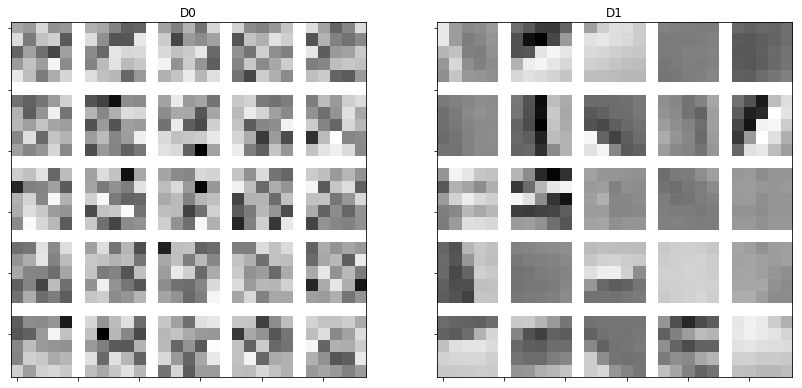

In [7]:
D1 = D1.squeeze()
fig = plot.figure(figsize=(14,7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D0[...,2,:]), fig=fig, title='D0')
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D1[...,2,:]), fig=fig, title='D1')
fig.show()

Display initial and final dictionaries: central spatial vertical slice

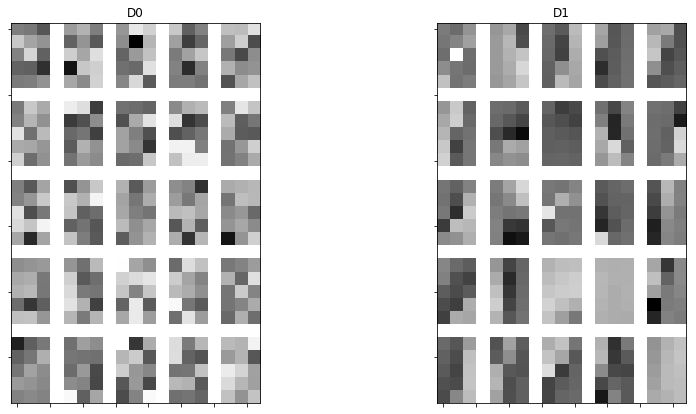

In [8]:
D1 = D1.squeeze()
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D0[2]), fig=fig, title='D0')
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D1[2]), fig=fig, title='D1')
fig.show()

Get iterations statistics from solver object and plot functional value, ADMM primary and dual residuals, and automatically adjusted ADMM penalty parameter against the iteration number.

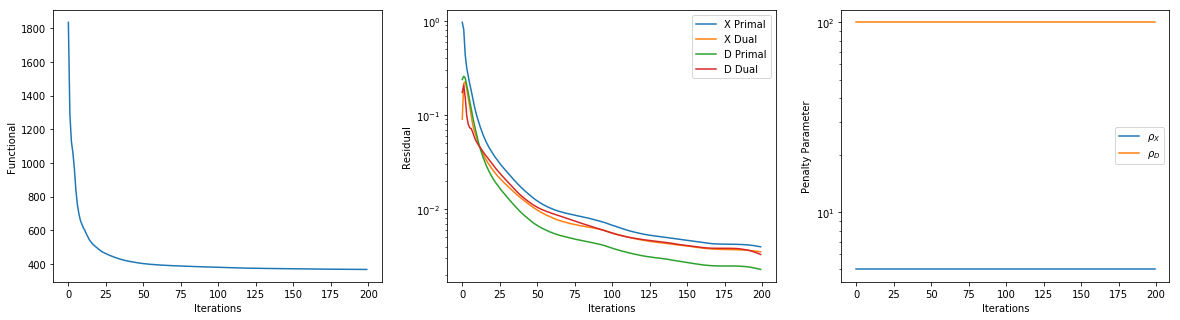

In [9]:
its = d.getitstat()
fig = plot.figure(figsize=(20, 5))
plot.subplot(1, 3, 1)
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional', fig=fig)
plot.subplot(1, 3, 2)
plot.plot(np.vstack((its.XPrRsdl, its.XDlRsdl, its.DPrRsdl, its.DDlRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['X Primal', 'X Dual', 'D Primal', 'D Dual'], fig=fig)
plot.subplot(1, 3, 3)
plot.plot(np.vstack((its.XRho, its.DRho)).T, xlbl='Iterations',
          ylbl='Penalty Parameter', ptyp='semilogy',
          lgnd=['$\\rho_X$', '$\\rho_D$'], fig=fig)
fig.show()